In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import DBSCAN
from model import SimCLRModel
from networks import MLP, DeepSetsEncoder
import torch.nn.functional as F
from tqdm import tqdm
import datasets, training
import augmentations as augs

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def make_corner(x,labels):
    N = x.size(1)
    blo,bhi = x.min(dim=0)[0].numpy(), x.max(dim=0)[0].numpy()
    fig,axes = plt.subplots(N,N,figsize=(N*2,N*2))
    for i in range(N):
        for j in range(N):
            plt.sca(axes[i,j])
            plt.axis('off')

    unique_labels = sorted(list(set(labels.numpy())))
    for il,label in enumerate(unique_labels):
        mask = labels==label
        xlims = []
        for i in range(N):
            plt.sca(axes[i,i])
            plt.axis('on')
            h = plt.hist(x[mask,i],bins=50,density=True,histtype='step')
            xlims.append(plt.gca().get_xlim())
        for i in range(1,N):
            for j in range(i):
                plt.sca(axes[i,j])
                plt.scatter(x[mask,j],x[mask,i],s=0.5)
                plt.xlim(xlims[i])

In [3]:
def pairwise_product_sum(x,normalize=True):
    if len(x.size()) == 2:
        x = x.unsqueeze(-1) # B, D, 1
    else:
        assert len(x.size()) == 3
    b,n,d = x.shape
    t1 = (x.sum(dim=1)**2).sum(dim=1) # sum(x_i)^2 
    t2 = (x**2).sum(dim=2).sum(dim=1) # sum(x_i^2)
    sums = 0.5 * (t1 - t2) # sum of all pairwise dot products
    if normalize:
        norm_dot = d
        norm_pairwise = 0.5 * (n**2 - n)
        sums = sums / (norm_dot * norm_pairwise)
    return sums

class PairwiseProducts:
    def __init__(self,
                 dim: int,
                 Cs: list[float],
                 sigmas: list[float],
                 interval: tuple = (0, 1),
                 fractions=None):
        
        self.dim = dim
        self.Cs = Cs
        self.sigmas = sigmas
        self.interval = interval
        self.fractions = fractions

    def generate_data(self,N):        
        if self.fractions is None:
            num_per = [int(N/len(self.Cs)) for i in range(len(self.Cs))]
        else:
            assert np.sum(self.fractions) == 1.0 and len(self.fractions) == len(self.Cs)
            num_per = [int(N*self.fractions[i]) for i in range(len(self.Cs))]
        num_per[-1] += N - np.sum(num_per)

        labels = np.arange(len(self.Cs))
        
        output = []
        sums = []
        indices = []
        labs = []

        for C,sigma,num,label in zip(self.Cs,self.sigmas,num_per,labels):
            n_yield = 0
            while n_yield < num:
                xC = self.interval[0] + (self.interval[1]-self.interval[0]) * torch.rand(num,self.dim)
                
                rand_indices = torch.randint(0,self.dim,(num,1)) # choose random element from each
                idx_tensor = torch.arange(self.dim).unsqueeze(0).repeat(num,1) # create index tensor
                target_sums = C + sigma*torch.randn(num) # want our function to equal this
                
                xC[idx_tensor==rand_indices] = 0.0 # zero out the selected elements of each vector
                sum_without_xsel = pairwise_product_sum(xC,normalize=False) # compute the function without the selected elements
                residuals = 0.5 * (self.dim**2 - self.dim) * target_sums - sum_without_xsel # compute residuals
                sum_other_elements = xC.sum(dim=1) # sum over the other elements
                replacements = residuals / sum_other_elements # compute the replacements
                xC[idx_tensor==rand_indices] = replacements
                
                mask = (replacements >= self.interval[0]) & (replacements <= self.interval[1]) # ensure all elements are in specified interval
                ngood = int(mask.float().sum().item())
                nmax = num-n_yield if n_yield+ngood > num else ngood
                n_yield += nmax

                xC = xC[mask][:ngood]
                target_sums = target_sums[mask][:ngood]
                rand_indices = rand_indices[mask][:ngood]

                output.append(xC)
                sums.append(target_sums)
                indices.append(rand_indices)
                labs.append(label*torch.ones(xC.size(0)))
        
        output = torch.cat(output,dim=0)
        sums = torch.cat(sums,dim=0)
        indices = torch.cat(indices,dim=0)
        labs = torch.cat(labs,dim=0)
        return output, sums, indices, labs
        
    def normalize(self,batch):
        return (batch - self.mean.to(batch)) / self.std.to(batch)

dataset $\mathbf{x} \sim U(0,1) \in \mathbb{R}^d$

compute
$$S = \sum_{i=1}^d\sum_{j>i}x_ix_j \sim \mathcal{N}(0.25,\sigma)$$
partition into classes $S < 0.25$, $S>0.25$

set $d=10$ and add 5 irrelevant noise dimensions $U(0,1)$ not used to define classes

augmentation = randomly permute the first 10 elements of $\mathbf{x}$

Train Loss: 0.1720, Val Loss: 0.1938: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


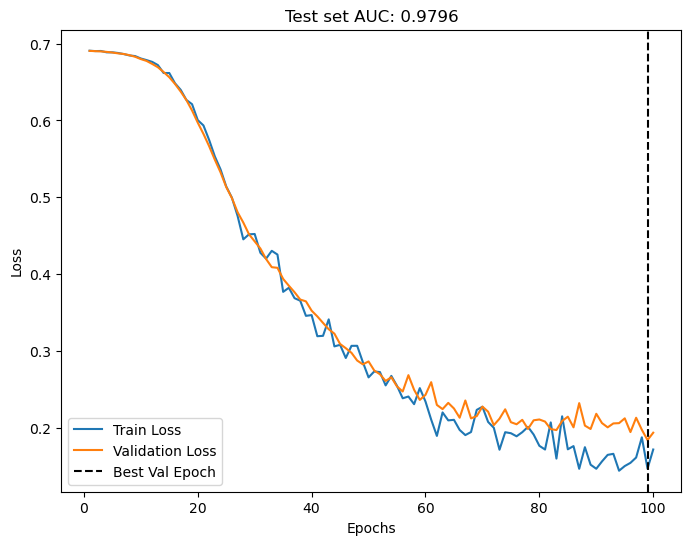

In [12]:
dim = 10
dim_noise = 5
N = 50000
f_labeled = 0.01
n_labeled = int(N*f_labeled)
nval = 10000
n_part = 5

train = datasets.PairwiseRandom(dim,dim_noise,n_labeled)
val = datasets.PairwiseRandom(dim,dim_noise,nval)
test = datasets.PairwiseRandom(dim,dim_noise,N-n_labeled)

hidden_dims = [32,32,32]
input_dim = dim + dim_noise
model_supervised_partialLabels = model = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,output_activation=nn.Sigmoid,dropout=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 100
bs = 128

model_supervised_partialLabels = training.supervised_training(model_supervised_partialLabels,train.loader(bs),val.loader(bs),test.loader(1000),optimizer,num_epochs=num_epochs,device=device)



In [110]:
dim = 10
dim_noise = 5
N = 50000
f_labeled = 0.01
n_labeled = int(N*f_labeled)
nval = 10000
n_part = 5

xtrain = torch.rand(20000,dim+dim_noise)
sums = pairwise_product_sum(xtrain[:,:dim])
lab_train = (sums>0.25).float()

xtest = torch.rand(20000,dim+dim_noise)
sums = pairwise_product_sum(xtest[:,:dim])
lab_test = (sums>0.25).float()

xval = torch.rand(nval,dim+dim_noise)
sums = pairwise_product_sum(xval[:,:dim])
lab_val = (sums>0.25).float()

In [111]:
from losses import SupervisedSimCLRLoss

dset_train = TensorDataset(xtrain,lab_train)
dset_val = TensorDataset(xval,lab_val)
batch_size = 512
dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dset_val, batch_size=batch_size, shuffle=True)

temp = 0.1
criterion = SupervisedSimCLRLoss(device=device,temperature=temp)

# Define the MLP model
embed_dim = 4
inner_dim = 16
#phi = MLP(input_dim=dim+dim_noise, hidden_dims=[32,32,32], output_dim=inner_dim, dropout=0.1).to(device)
#f = MLP(input_dim=inner_dim, hidden_dims=[64,64,64], output_dim=embed_dim, dropout=0.1).to(device)
#embedder = DeepSetsEncoder(phi,f).to(device)
embedder = MLP(input_dim=dim+dim_noise,hidden_dims=[64,64,64],output_dim=embed_dim)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model_contra = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model_contra.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
batch_size = 512
dset_train = TensorDataset(xtrain,lab_train)
dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)

losses = []
val_losses = []
best_state = None
min_loss = 9999
best_epoch = 0
for epoch in tqdm(range(num_epochs)):
    model_contra.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float()
        randperm0 = torch.argsort(torch.rand(*batch_data[:,:dim].shape),dim=1)
        randperm1 = torch.argsort(torch.rand(*batch_data[:,:dim].shape),dim=1)
        
        aug0 = batch_data.clone()
        aug0[:,:dim] = aug0[torch.arange(batch_data.size(0)).unsqueeze(-1),
                              randperm0]
        aug0 = aug0.to(device)
        
        aug1 = batch_data.clone()
        aug1[:,:dim] = aug1[torch.arange(batch_data.size(0)).unsqueeze(-1),
                              randperm1].to(device)
        aug1 = aug1.to(device)

        #noise_eps = 0.01
        #aug0 = batch_data.clone().to(device) + torch.randn(*batch_data.shape).to(device) * noise_eps
        #aug1 = batch_data.clone().to(device) + torch.randn(*batch_data.shape).to(device) * noise_eps

        # reshape to go into deep sets arch
        #aug0 = aug0.unsqueeze(-1)
        #aug1 = aug1.unsqueeze(-1)
        
        # Forward pass
        features_0 = F.normalize(model_contra(aug0),dim=1).unsqueeze(1)
        features_1 = F.normalize(model_contra(aug1),dim=1).unsqueeze(1)
        features = torch.cat([features_0, features_1], dim=1)
        
        # Compute SimCLR loss
        loss = criterion(features,labels=None)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    
    epoch_loss = []
    with torch.no_grad():
        for batch, labels in dataloader_val:
            batch = batch.float()
            randperm0 = torch.argsort(torch.rand(*batch[:,:dim].shape),dim=1)
            randperm1 = torch.argsort(torch.rand(*batch[:,:dim].shape),dim=1)
            
            aug0 = batch.clone()
            aug0[:,:dim] = aug0[torch.arange(batch.size(0)).unsqueeze(-1),
                                 randperm0]
            aug0 = aug0.to(device)
            
            aug1 = batch.clone()
            aug1[:,:dim] = aug1[torch.arange(batch.size(0)).unsqueeze(-1),
                                 randperm1]
            aug1 = aug1.to(device)

            # reshape to go into deep sets arch
            #aug0 = aug0.unsqueeze(-1)
            #aug1 = aug1.unsqueeze(-1)

            # Forward pass
            features_0 = F.normalize(model_contra(aug0),dim=1).unsqueeze(1)
            features_1 = F.normalize(model_contra(aug1),dim=1).unsqueeze(1)
            features = torch.cat([features_0, features_1], dim=1)

            # Compute SimCLR loss
            loss = criterion(features,labels=None)
            
            epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    val_losses.append(mean_loss)
    if mean_loss < min_loss:
        min_loss = mean_loss
        best_state = model_contra.state_dict()
        best_epoch = epoch

model_contra.load_state_dict(best_state)
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)
plt.axvline(best_epoch,color='k',linestyle='--')

In [117]:
model_contra.load_state_dict(torch.load('model_contra.pt'))
dim = 10
dim_noise = 5
N = 50000
f_labeled = 0.01
n_labeled = int(N*f_labeled)
nval = 10000
n_part = 5

xtrain = torch.rand(20000,dim+dim_noise)
sums = pairwise_product_sum(xtrain[:,:dim])
lab_train = (sums>0.25).float()

xtest = torch.rand(20000,dim+dim_noise)
sums = pairwise_product_sum(xtest[:,:dim])
lab_test = (sums>0.25).float()

xval = torch.rand(nval,dim+dim_noise)
sums = pairwise_product_sum(xval[:,:dim])
lab_val = (sums>0.25).float()

In [118]:
with torch.no_grad():
    xtrain = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtrain,1000)],dim=0)
    xtest = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtest,1000)],dim=0)
    xval = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xval,1000)],dim=0)

In [119]:
make_corner(xtest,lab_test)

In [120]:
dim = 10
dim_noise = 5
N = 50000
f_labeled = 0.01
n_labeled = int(N*f_labeled)
nval = 10000
n_part = 5

xtrain = torch.rand(n_labeled,dim+dim_noise)
sums = pairwise_product_sum(xtrain[:,:dim])
lab_train = (sums>0.25).float()

xtest = torch.cat([xtrain,torch.rand(N-n_labeled,dim+dim_noise)],dim=0)
sums = pairwise_product_sum(xtest[:,:dim])
lab_test = (sums>0.25).float()

xval = torch.rand(nval,dim+dim_noise)
sums = pairwise_product_sum(xval[:,:dim])
lab_val = (sums>0.25).float()

model_contra = model_contra.eval()
with torch.no_grad():
    xtrain = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtrain,1000)],dim=0)
    xtest = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtest,1000)],dim=0)
    xval = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xval,1000)],dim=0)

In [121]:
# train an MLP to discriminate 
input_dim = xtrain.size(1)
hidden_dims = [32,32,32]
model = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,output_activation=nn.Sigmoid,dropout=0.1).to(device)
#inner_dim = 16
#output_dim = 1
#phi = MLP(input_dim=dim+dim_noise, hidden_dims=[32,32,32], output_dim=inner_dim).to(device)
#f = MLP(input_dim=inner_dim, hidden_dims=[64,64,64], output_dim=1,output_activation=nn.Sigmoid).to(device)
#model = DeepSetsEncoder(phi,f).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
dset_train = TensorDataset(xtrain,lab_train)
dset_val = TensorDataset(xval,lab_val)
batch_size = 128

dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dset_val, batch_size=10000, shuffle=True)
criterion = nn.BCELoss()
# training loop
num_epochs = 500
losses = []
val_losses = []
best_state = None
min_loss = 9999
best_epoch = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        labels = labels.float().unsqueeze(1).to(device)
        output = model(batch_data.to(device))
        # bce loss
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)

    epoch_loss = []
    with torch.no_grad():
        for batch, labels in dataloader_val:
            labels = labels.float().unsqueeze(1).to(device)
            output = model(batch.to(device))
            # bce loss
            loss = criterion(output,labels)
            epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    val_losses.append(mean_loss)
    if mean_loss < min_loss:
        min_loss = mean_loss
        best_state = model.state_dict()
        best_epoch = epoch
    
model.load_state_dict(best_state)

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)
plt.axvline(best_epoch,color='k',linestyle='--')

# testing evaluation
model.eval()
with torch.no_grad():
    output = []
    for sp in torch.split(xtest,10000):
        output.append(model(sp.to(device)).cpu().numpy())
    output = np.concatenate(output,axis=0)
    labels = lab_test.numpy()
    # compute ROC AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels,output)
    print(f"ROC AUC: {auc}")

In [133]:
dim = 10
dim_noise = 5

xtrain = torch.rand(20000,dim+dim_noise)
sums = pairwise_product_sum(xtrain[:,:dim])
lab_train = (sums>0.25).float()

xtest = torch.rand(50000,dim+dim_noise)
sums = pairwise_product_sum(xtest[:,:dim])
lab_test = (sums>0.25).float()

xval = torch.rand(10000,dim+dim_noise)
sums = pairwise_product_sum(xval[:,:dim])
lab_val = (sums>0.25).float()

model_contra = model_contra.eval()
with torch.no_grad():
    xtrain = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtrain,1000)],dim=0)
    xtest = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xtest,1000)],dim=0)
    xval = torch.cat([model_contra(xi.to(device)).cpu() for xi in torch.split(xval,1000)],dim=0)

In [134]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(xtrain)

xtrain_gmm = gmm.predict(xtrain)
xtest_gmm = gmm.predict(xtest)
xval_gmm = gmm.predict(xval)

In [142]:
# train an MLP to discriminate 
input_dim = xtrain.size(1)
hidden_dims = [32,32,32]
model = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,output_activation=nn.Sigmoid,dropout=0.1).to(device)
#inner_dim = 16
#output_dim = 1
#phi = MLP(input_dim=dim+dim_noise, hidden_dims=[32,32,32], output_dim=inner_dim).to(device)
#f = MLP(input_dim=inner_dim, hidden_dims=[64,64,64], output_dim=1,output_activation=nn.Sigmoid).to(device)
#model = DeepSetsEncoder(phi,f).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
dset_train = TensorDataset(xtrain,torch.tensor(xtrain_gmm))
dset_val = TensorDataset(xval,torch.tensor(xval_gmm))
batch_size = 128

dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dset_val, batch_size=10000, shuffle=True)
criterion = nn.BCELoss()
# training loop
num_epochs = 100
losses = []
val_losses = []
best_state = None
min_loss = 9999
best_epoch = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        labels = labels.float().unsqueeze(1).to(device)
        output = model(batch_data.to(device))
        # bce loss
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)

    epoch_loss = []
    with torch.no_grad():
        for batch, labels in dataloader_val:
            labels = labels.float().unsqueeze(1).to(device)
            output = model(batch.to(device))
            # bce loss
            loss = criterion(output,labels)
            epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    val_losses.append(mean_loss)
    if mean_loss < min_loss:
        min_loss = mean_loss
        best_state = model.state_dict()
        best_epoch = epoch
    
model.load_state_dict(best_state)

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)
plt.axvline(best_epoch,color='k',linestyle='--')

# testing evaluation
model.eval()
with torch.no_grad():
    output = []
    for sp in torch.split(xtest,10000):
        output.append(model(sp.to(device)).cpu().numpy())
    output = np.concatenate(output,axis=0)
    labels = xtest_gmm
    # compute ROC AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels,output)
    print(f"ROC AUC: {auc}")

In [143]:
model_contra